# Multi-Sensor Lake Ice Phenology Detection
## Alaska Thermokarst Lakes - Sentinel-1 + Sentinel-2 + ERA5 Approach

**Goal:** Detect ice-on and ice-off dates for ~550 Alaska lakes using multi-sensor fusion

**Approach:**
1. Use Sentinel-2 NDSI as high-confidence ground truth (after clouds filter, and excluding summer algal blooms based on ERA5 temperature)
2. Train Random Forest on S1 features using S2 labels
3. Use the trained model to interpolate between S2 observations
4. Use all three datasets to detect ice-on/ice-off dates
   
**Loosely based on (more like inspired by):** [Tom et al. (2020)](https://isprs-annals.copernicus.org/articles/V-3-2020/409/2020/isprs-annals-V-3-2020-409-2020.pdf) - using optical data to train SAR interpretation

---
## Part 1: Setup and Configuration

In [1]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Initialize Earth Engine
ee.Initialize()

print("Imports successful!")
print(f"Earth Engine initialized: {ee.String('GEE Initialized').getInfo()}")

/opt/conda/envs/gee/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.


Imports successful!
Earth Engine initialized: GEE Initialized


In [2]:
# Configuration
YEAR = 2023
BUCKET = 'wustl-eeps-geospatial'
LAKE_ASSET = 'projects/eeps-geospatial/assets/alaska_lakes' 
LAKE_ID_FIELD = 'id'
SCALE = 10  # Sentinel-1 resolution

# Use Alaska Albers equal area projection for lake areas
proj_ak = ee.Projection('EPSG:3338')

print(f"Configuration set for year {YEAR}")
print(f"Will export to gs://{BUCKET}/thermokarst_lakes/")

Configuration set for year 2023
Will export to gs://wustl-eeps-geospatial/thermokarst_lakes/


---
## Part 2: Load and Prepare Lake Geometries

In [3]:
# Load lakes from GEE Asset collection (Claire's shapefile)
lakes = ee.FeatureCollection(LAKE_ASSET)
print(f"Loaded {lakes.size().getInfo()} lakes")

# Add lake geometries
def add_geom_metrics(feat):
    geom = feat.geometry().transform(proj_ak, 1)
    area = geom.area(1)
    perim = geom.perimeter(1)
    centroid = geom.centroid(1)
    coords = centroid.coordinates()
    
    # Existing metrics
    circularity = ee.Number(4).multiply(ee.Number(np.pi)).multiply(area).divide(perim.pow(2))
    
    # Fractal dimension ish (perimeter-area relationship)
    # D = 2 * ln(perimeter/4) / ln(area)
    fractal_dim = ee.Number(2).multiply(
        perim.divide(4).log().divide(area.log())
    )
    
    # Convexity
    convex_hull = geom.convexHull(1)
    convex_area = convex_hull.area(1)
    convexity = area.divide(convex_area)
    
    return feat.set({
        'lake_area_m2': area,
        'lake_perim_m': perim,
        'circularity': circularity,
        'fractal_dim': fractal_dim,
        'convexity': convexity,
        'centroid_lon': coords.get(0),
        'centroid_lat': coords.get(1)
    })

lakes_with_geom = lakes.map(add_geom_metrics)

# Create buffered lake interiors to get rid of that weird area with thin ice
def buffer_interior(feat):
    geom = feat.geometry()
    area = geom.area()
    
    # Use fixed 10m negative buffer
    # previously tried keeping interior 67% approach but
    # it was too aggressive on small lakes
    buffered = geom.buffer(-10)
    # For very small lakes, just use original geometry
    buffered = ee.Algorithms.If(
        area.lt(10000),  # If lake < 10,000 m^2
        geom,            # Use full lake
        buffered         # Otherwise use 10m buffer
    )   
    return feat.setGeometry(ee.Geometry(buffered))

lakes_buf = lakes_with_geom.map(buffer_interior)

# Create landscape rings (100m around lakes. This might be too big?)
def create_landscape_ring(feat):
    lake_geom = feat.geometry()
    outer_buffer = lake_geom.buffer(100)
    ring = outer_buffer.difference(lake_geom)
    return feat.setGeometry(ring)

landscape_rings = lakes_with_geom.map(create_landscape_ring)

print("Lake geometries prepared:")
print("  - Original lakes")
print("  - Buffered interiors (10m)")
print("  - Landscape rings (100m)")

Loaded 541 lakes
Lake geometries prepared:
  - Original lakes
  - Buffered interiors (10m)
  - Landscape rings (100m)


---
## Part 3: Define Data Collection Functions

In [19]:
# Sentinel-1 collection
def get_s1_collection(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    coll = (ee.ImageCollection('COPERNICUS/S1_GRD')
            .filterBounds(lakes.geometry())
            .filterDate(start, end)
            .filter(ee.Filter.eq('instrumentMode', 'IW'))
            .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
            .filter(ee.Filter.eq('relativeOrbitNumber_start', 102))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
            .filter(ee.Filter.eq('resolution_meters', 10)))
    
    def prep_s1(img):
        angle = img.select('angle')
        angle_mask = angle.gt(25).And(angle.lt(50))
        
        # Process VV
        vv_lin = ee.Image(10.0).pow(img.select('VV').divide(10.0)).updateMask(angle_mask)
        vv_lin_f = vv_lin.focal_mean(1)
        vv_db = vv_lin_f.log10().multiply(10).rename('VV_db')
        
        # Process VH
        vh_lin = ee.Image(10.0).pow(img.select('VH').divide(10.0)).updateMask(angle_mask)
        vh_lin_f = vh_lin.focal_mean(1)
        vh_db = vh_lin_f.log10().multiply(10).rename('VH_db')
        
        return vv_db.addBands(vh_db).copyProperties(img, img.propertyNames())
    
    return coll.map(prep_s1)

# Sentinel-2 collection with s2cloudless pixel-level cloud masking
def get_s2_collection(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    # Get S2 SR collection
    s2_sr = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterBounds(lakes.geometry())
            .filterDate(start, end)
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 80))) #move up to 80 and use s2cloudless
    
    # Get s2cloudless collection. using this instead of QA60
    s2_cloudless = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
                    .filterBounds(lakes.geometry())
                    .filterDate(start, end))
    
    # Join the two collections
    def join_collections(s2_img):
        # Find matching s2cloudless image (within 1 hour)
        time_diff = ee.Filter.maxDifference(
            difference=1 * 60 * 60 * 1000,  # 1 hour in milliseconds
            leftField='system:time_start',
            rightField='system:time_start'
        )
        join = ee.Join.saveFirst('cloud_mask')
        joined = ee.ImageCollection(join.apply(
            ee.ImageCollection([s2_img]),
            s2_cloudless,
            time_diff
        ))
        return ee.Image(joined.first())
    
    def compute_ndsi(img):
        # Get cloud probability
        cloud_prob = ee.Image(img.get('cloud_mask')).select('probability')
        
        # Cloud mask: probability < 20%
        is_not_cloud = cloud_prob.lt(20)
        
        # NDSI = (Green - SWIR1) / (Green + SWIR1)
        ndsi = img.normalizedDifference(['B3', 'B11']).rename('ndsi').updateMask(is_not_cloud)
        
        # Ice mask: NDSI > 0.45 (tightened this from 0.4)
        ice_mask = ndsi.gt(0.45).rename('ice')
        
        return img.addBands(ndsi).addBands(ice_mask).addBands(cloud_prob.rename('cloud_prob'))
    
    # Apply join and compute NDSI
    joined = s2_sr.map(join_collections)
    return joined.map(compute_ndsi)

# ERA5 temperature collection
def get_era5_collection(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    # Get daily mean temperature
    era5 = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').filterDate(start, end).select('temperature_2m')
    
    # Convert to daily means
    days = ee.List.sequence(0, 364)  # 365 days
    
    def daily_mean(day):
        date = start.advance(day, 'day')
        daily = era5.filterDate(date, date.advance(1, 'day')).mean()
        # Convert Kelvin to Celsius
        temp_c = daily.subtract(273.15).rename('temp_c')
        return temp_c.set('system:time_start', date.millis())
    
    return ee.ImageCollection.fromImages(days.map(daily_mean))

print("Data collection functions defined")

Data collection functions defined


---
## Part 4: Export Multi-Sensor Data

This will export three separate CSVs:
1. Sentinel-1 time series (VV, VH, RGB features)
2. Sentinel-2 time series (NDSI, ice fraction)
3. ERA5 daily temperature

We'll merge them later in Python.

In [22]:
# Load collections
s1 = get_s1_collection(YEAR)
s2 = get_s2_collection(YEAR)
era5 = get_era5_collection(YEAR)

# Get all unique paths in the S1 collection
def get_path(img):
    return ee.Feature(None, {'path': img.get('relativeOrbitNumber_start')})
paths = s1.map(get_path).distinct('path').aggregate_array('path').getInfo()

print(f"S1 images: {s1.size().getInfo()}")
print(f"Unique paths in S1 collection: {sorted(paths)}")
print(f"S2 images: {s2.size().getInfo()}")
print(f"ERA5 daily images: {era5.size().getInfo()}")

S1 images: 30
Unique paths in S1 collection: [102]
S2 images: 737
ERA5 daily images: 365


### Export 1: Sentinel-1 Data

In [23]:
def s1_to_features(img):
    vv_img = img.select('VV_db')
    vh_img = img.select('VH_db')
    
    # RGB bands
    r_band = vv_img.unitScale(-20, -5).multiply(255).byte().rename('R')
    g_band = vh_img.unitScale(-28, -12).multiply(255).byte().rename('G')
    b_band = vv_img.subtract(vh_img).unitScale(8, 18).multiply(255).byte().rename('B')
    
    rgb_img = ee.Image.cat([r_band, g_band, b_band])
    date_str = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
    
    # Reducers
    vv_reducer = ee.Reducer.mean().combine(ee.Reducer.count(), sharedInputs=True)
    vh_reducer = ee.Reducer.mean()
    rgb_reducer = ee.Reducer.mean()
    
    # Reduce over lake interiors
    vv_stats = vv_img.reduceRegions(
        collection=lakes_buf,
        reducer=vv_reducer,
        scale=SCALE,
        tileScale=2
    )
    
    vh_stats = vh_img.reduceRegions(
        collection=lakes_buf,
        reducer=vh_reducer,
        scale=SCALE,
        tileScale=2
    )
    
    rgb_stats = rgb_img.reduceRegions(
        collection=lakes_buf,
        reducer=rgb_reducer,
        scale=SCALE,
        tileScale=2
    )
    
    # Landscape context
    land_stats = rgb_img.reduceRegions(
        collection=landscape_rings,
        reducer=rgb_reducer,
        scale=SCALE,
        tileScale=2
    )
    
    def add_metadata(f):
        lake_id_prop = f.get(LAKE_ID_FIELD)
        
        # Get stats for this lake
        vh_feature = vh_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        rgb_feature = rgb_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        land_feature = land_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        
        # Get geometry metrics from original
        orig = lakes_with_geom.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        
        # FIXED: Handle null VH values safely
        vv_val = ee.Number(f.get('mean'))
        vh_val = ee.Number(vh_feature.get('mean'))
        
        # Only compute ratio if both values exist
        vv_vh_ratio = ee.Algorithms.If(
            vh_feature.get('mean'),  # Check if VH exists
            vv_val.subtract(vh_val),  # Compute if exists
            ee.Number(-999)  # Null flag if missing
        )
        
        return (f.set('date', date_str)
                .set('sensor', 'S1')
                .set('vv_db', vv_val)
                .set('vh_db', vh_val)
                .set('vv_vh_ratio', vv_vh_ratio)
                .set('lake_R', rgb_feature.get('R'))
                .set('lake_G', rgb_feature.get('G'))
                .set('lake_B', rgb_feature.get('B'))
                .set('land_R', land_feature.get('R'))
                .set('land_G', land_feature.get('G'))
                .set('land_B', land_feature.get('B'))
                .set('lake_area_m2', orig.get('lake_area_m2'))
                .set('centroid_lon', orig.get('centroid_lon'))
                .set('centroid_lat', orig.get('centroid_lat'))
                .set('lake_id', ee.Number(lake_id_prop).toInt()))
    
    return vv_stats.map(add_metadata)

# Map over S1 images
s1_features = s1.map(s1_to_features).flatten()

# Export
s1_cols = [
    'lake_id', 'date', 'sensor',
    'vv_db', 'vh_db', 'vv_vh_ratio',
    'lake_R', 'lake_G', 'lake_B',
    'land_R', 'land_G', 'land_B',
    'lake_area_m2', 'centroid_lon', 'centroid_lat'
]

task_s1 = ee.batch.Export.table.toCloudStorage(
    collection=s1_features.select(s1_cols),
    description=f'Alaska_Lakes_S1_{YEAR}',
    bucket=BUCKET,
    fileNamePrefix=f'thermokarst_lakes/Alaska_Lakes_S1_{YEAR}',
    fileFormat='CSV',
    selectors=s1_cols
)

task_s1.start()
print(f"Started S1 export: {task_s1.id}")

Started S1 export: KVXWTNLWX7TJAWVPLK4F64GE


### Export 2: Sentinel-2 Data

In [7]:
def s2_to_features(img):
    """
    Only export S2 data for lakes that this image actually covers
    """
    ice_img = img.select('ice')
    ndsi_img = img.select('ndsi')
    date_str = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
    
    # Only process lakes that intersect this image's footprint
    img_bounds = img.geometry()
    lakes_in_image = lakes_buf.filterBounds(img_bounds)
    
    # Reduce over lake interiors (only those in this image)
    ice_stats = ice_img.reduceRegions(
        collection=lakes_in_image,  # Only lakes covered by this image
        reducer=ee.Reducer.mean(),
        scale=20,  # S2 SWIR resolution
        tileScale=2
    )
    
    ndsi_stats = ndsi_img.reduceRegions(
        collection=lakes_in_image,  # Only lakes covered by this image
        reducer=ee.Reducer.mean(),
        scale=20,
        tileScale=2
    )
    
    def add_metadata(f):
        lake_id_prop = f.get(LAKE_ID_FIELD)
        ndsi_feature = ndsi_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        orig = lakes_with_geom.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        
        return (f.set('date', date_str)
                .set('sensor', 'S2')
                .set('ice_fraction', f.get('mean'))  # Fraction of pixels with ice
                .set('ndsi_mean', ndsi_feature.get('mean'))
                .set('lake_area_m2', orig.get('lake_area_m2'))
                .set('centroid_lon', orig.get('centroid_lon'))
                .set('centroid_lat', orig.get('centroid_lat'))
                .set('lake_id', ee.Number(lake_id_prop).toInt()))
    
    return ice_stats.map(add_metadata)

# Map over S2 images
s2_features = s2.map(s2_to_features).flatten()

# Export
s2_cols = [
    'lake_id', 'date', 'sensor',
    'ice_fraction', 'ndsi_mean',
    'lake_area_m2', 'centroid_lon', 'centroid_lat'
]

task_s2 = ee.batch.Export.table.toCloudStorage(
    collection=s2_features.select(s2_cols),
    description=f'Alaska_Lakes_S2_{YEAR}',
    bucket=BUCKET,
    fileNamePrefix=f'thermokarst_lakes/Alaska_Lakes_S2_{YEAR}',
    fileFormat='CSV',
    selectors=s2_cols
)

task_s2.start()
print(f"Started S2 export: {task_s2.id}")

Started S2 export: BKW3QQWUYZGLCDXCFLY6IIXF


### Export 3: ERA5 Temperature Data

In [8]:
# Get ERA5 as daily image collection
def get_era5_daily_grid(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    era5 = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').filterDate(start, end).select('temperature_2m')
    
    # Create daily means
    days = ee.List.sequence(0, 364)
    
    def daily_mean(day):
        date = start.advance(day, 'day')
        daily = era5.filterDate(date, date.advance(1, 'day')).mean()
        temp_c = daily.subtract(273.15).rename('temp_c')
        return temp_c.set('system:time_start', date.millis()).set('date', date.format('YYYY-MM-dd'))
    
    return ee.ImageCollection.fromImages(days.map(daily_mean))

era5_daily = get_era5_daily_grid(YEAR)

# Create point features at lake centroids
lake_points = lakes_with_geom.map(
    lambda f: ee.Feature(
        f.geometry().centroid(),
        {
            'lake_id': f.get(LAKE_ID_FIELD),
            'centroid_lon': f.get('centroid_lon'),
            'centroid_lat': f.get('centroid_lat')
        }
    )
)

print(f"Created {lake_points.size().getInfo()} lake centroid points")

# Sample temperature at each lake centroid for each day
def sample_at_lakes(img):
    date_str = img.get('date')
    
    # Sample at points - one point per lake should be fine
    samples = img.select('temp_c').sampleRegions(
        collection=lake_points,
        scale=11000,
        geometries=False
    )
    
    # Add date to each sample
    def add_date(f):
        return f.set('date', date_str).set('sensor', 'ERA5')
    
    return samples.map(add_date)

print("Sampling ERA5 at lake centroids...")
era5_features = era5_daily.map(sample_at_lakes).flatten()

# Export
era5_cols = ['lake_id', 'date', 'sensor', 'temp_c', 'centroid_lon', 'centroid_lat']

task_era5 = ee.batch.Export.table.toCloudStorage(
    collection=era5_features.select(era5_cols),
    description=f'Alaska_Lakes_ERA5_{YEAR}',
    bucket=BUCKET,
    fileNamePrefix=f'thermokarst_lakes/Alaska_Lakes_ERA5_{YEAR}',
    fileFormat='CSV',
    selectors=era5_cols
)

task_era5.start()
print(f"Started ERA5 export: {task_era5.id}")

Created 541 lake centroid points
Sampling ERA5 at lake centroids...
Started ERA5 export: EZMCLODQ2DWUMBNLNH4Y4B5V


---
## Part 5: Load and Merge Multi-Sensor Data

**Wait to do this step until the exports all complete**

In [30]:
# Load the CSVs
df_s1 = pd.read_csv(f'gs://{BUCKET}/thermokarst_lakes/Alaska_Lakes_S1_2023.csv')
df_s2 = pd.read_csv(f'gs://{BUCKET}/thermokarst_lakes/Alaska_Lakes_S2_2023.csv')
df_era5 = pd.read_csv(f'gs://{BUCKET}/thermokarst_lakes/Alaska_Lakes_ERA5_2023.csv')

# Convert dates
df_s1['date'] = pd.to_datetime(df_s1['date'])
df_s2['date'] = pd.to_datetime(df_s2['date'])
df_era5['date'] = pd.to_datetime(df_era5['date'])

print("Data loaded:")
print(f"  S1:   {len(df_s1):,} observations across {df_s1['lake_id'].nunique()} lakes")
print(f"  S2:   {len(df_s2):,} observations across {df_s2['lake_id'].nunique()} lakes")
print(f"  ERA5: {len(df_era5):,} observations across {df_era5['lake_id'].nunique()} lakes")

# Merge S1 + temperature (every S1 obs gets a temp)
df_s1 = df_s1.merge(df_era5[['lake_id', 'date', 'temp_c']], on=['lake_id', 'date'], how='left')

print(f"\nMerged S1 + temperature: {len(df_s1):,} observations")
print(f"Temperature coverage: {df_s1['temp_c'].notna().sum() / len(df_s1) * 100:.1f}%")

Data loaded:
  S1:   16,230 observations across 541 lakes
  S2:   100,311 observations across 541 lakes
  ERA5: 191,625 observations across 525 lakes

Merged S1 + temperature: 16,230 observations
Temperature coverage: 97.0%


In [31]:
# Deduplicate: keep only one S2 observation per lake per date
before_count = len(df_s2)
print(f"Before deduplication: {before_count:,} rows")

# For duplicates, keep the one with least ambiguous ice_fraction (furthest from 0.5)
df_s2['confidence'] = (df_s2['ice_fraction'] - 0.5).abs()
df_s2 = df_s2.sort_values('confidence', ascending=False).drop_duplicates(
    subset=['lake_id', 'date'], 
    keep='first'
)
df_s2 = df_s2.drop(columns='confidence')

after_count = len(df_s2)
print(f"After deduplication:  {after_count:,} rows")
print(f"Removed {before_count - after_count:,} duplicate observations ({(before_count - after_count) / before_count * 100:.1f}%)")

Before deduplication: 100,311 rows
After deduplication:  55,247 rows
Removed 45,064 duplicate observations (44.9%)


In [32]:
# S2 coverage statistics
print("\nSentinel-2 Coverage Analysis:")
print("="*60)

s2_per_lake = df_s2.groupby('lake_id').size()
print(f"S2 observations per lake:")
print(f"  Mean:   {s2_per_lake.mean():.1f}")
print(f"  Median: {s2_per_lake.median():.0f}")
print(f"  Min:    {s2_per_lake.min():.0f}")
print(f"  Max:    {s2_per_lake.max():.0f}")

# Merge temperature onto S2 data for label cleaning
print("\nMerging temperature data onto S2 observations...")
df_s2 = df_s2.merge(df_era5[['lake_id', 'date', 'temp_c']], 
                    on=['lake_id', 'date'], how='left')
print(f"Temperature coverage in S2 data: {df_s2['temp_c'].notna().sum() / len(df_s2) * 100:.1f}%")

# Add month for diagnostics
df_s2['month'] = df_s2['date'].dt.month

# Compute 7-day rolling mean temperature for each lake
print("\nComputing 7-day temperature trends...")
df_s2 = df_s2.sort_values(['lake_id', 'date'])
df_s2['temp_7day_mean'] = df_s2.groupby('lake_id')['temp_c'].transform(
    lambda x: x.rolling(window=7, min_periods=3, center=False).mean()
)

# Create initial ice state labels from S2
df_s2['s2_ice_state'] = 'PARTIAL'
df_s2.loc[df_s2['ice_fraction'] > 0.6, 's2_ice_state'] = 'ICE'    
df_s2.loc[df_s2['ice_fraction'] < 0.4, 's2_ice_state'] = 'WATER'

print(f"\nInitial S2 ice classification:")
print(df_s2['s2_ice_state'].value_counts())

# Identify suspicious detections to EXCLUDE from training
ice_labels = df_s2['s2_ice_state'] == 'ICE'
water_labels = df_s2['s2_ice_state'] == 'WATER'
temp_7day_available = df_s2['temp_7day_mean'].notna()

# Flag suspicious observations
suspicious_ice_warm = (ice_labels & temp_7day_available & 
                       (df_s2['temp_7day_mean'] > 5))
suspicious_water_cold = (water_labels & temp_7day_available & 
                         (df_s2['temp_7day_mean'] < -5))

# Mark as EXCLUDED
df_s2.loc[suspicious_ice_warm | suspicious_water_cold, 's2_ice_state'] = 'EXCLUDED'

print(f"\nAfter marking suspicious observations:")
print(df_s2['s2_ice_state'].value_counts())
print(f"  Excluded as suspicious ICE (7-day mean temp > 5°C): {suspicious_ice_warm.sum()}")
print(f"  Excluded as suspicious WATER (7-day mean temp < -5°C): {suspicious_water_cold.sum()}")

# Clear labels for training: only ICE or WATER, not EXCLUDED or PARTIAL
clear_labels = df_s2['s2_ice_state'].isin(['ICE', 'WATER'])
print(f"\nClear detections for training (ICE or WATER): {clear_labels.sum()} ({clear_labels.sum() / len(df_s2) * 100:.1f}%)")


Sentinel-2 Coverage Analysis:
S2 observations per lake:
  Mean:   102.1
  Median: 101
  Min:    78
  Max:    140

Merging temperature data onto S2 observations...
Temperature coverage in S2 data: 97.0%

Computing 7-day temperature trends...

Initial S2 ice classification:
s2_ice_state
PARTIAL    43873
ICE         8003
WATER       3371
Name: count, dtype: int64

After marking suspicious observations:
s2_ice_state
PARTIAL     43873
ICE          7441
WATER        3371
EXCLUDED      562
Name: count, dtype: int64
  Excluded as suspicious ICE (7-day mean temp > 5°C): 562
  Excluded as suspicious WATER (7-day mean temp < -5°C): 0

Clear detections for training (ICE or WATER): 10812 (19.6%)


In [33]:
# Identify remaining suspicious summer ice detections
print("\n" + "="*60)
print("Summer Ice Detection Quality Check")
print("="*60)

summer_months = df_s2['date'].dt.month.isin([6, 7, 8])
has_ice = df_s2['ice_fraction'] > 0.2
warm_temp = df_s2['temp_c'] > 5

suspicious_summer = df_s2[summer_months & has_ice & warm_temp].copy()

print(f"\nSuspicious summer 'ice' detections (Jun-Aug, ice_fraction>0.2, temp>5°C):")
print(f"  Total observations: {len(suspicious_summer)}")
if len(suspicious_summer) > 0:
    print(f"  Mean ice_fraction: {suspicious_summer['ice_fraction'].mean():.2f}")
    print(f"  Mean temperature: {suspicious_summer['temp_c'].mean():.1f}°C")
    print(f"  Mean NDSI: {suspicious_summer['ndsi_mean'].mean():.2f}")
    
    print("\n  Sample of suspicious detections:")
    sample = suspicious_summer[['lake_id', 'date', 'ice_fraction', 'ndsi_mean', 'temp_c', 's2_ice_state']].head(10)
    print(sample.to_string(index=False))
    
    # Check if temperature filtering caught most of them
    still_labeled_ice = (suspicious_summer['s2_ice_state'] == 'ICE').sum()
    print(f"\n  Still labeled as ICE after temperature filtering: {still_labeled_ice}")
    print(f"  Successfully relabeled as WATER: {len(suspicious_summer) - still_labeled_ice}")
else:
    print("  None found - temperature filtering working well!")

if len(suspicious_summer) > 0:
    # Export suspicious detections to csv
    suspicious_export = suspicious_summer[['lake_id', 'date', 'ice_fraction', 'ndsi_mean', 
                                           'temp_c', 'temp_7day_mean', 's2_ice_state', 
                                           'centroid_lat', 'centroid_lon']].copy()
    
    suspicious_export.to_csv('suspicious_summer_ice_detections.csv', index=False)
    print(f"\n✓ Exported {len(suspicious_export)} suspicious detections to suspicious_summer_ice_detections.csv")
    
    # Summary stats by lake
    by_lake = suspicious_export.groupby('lake_id').size().sort_values(ascending=False)
    print(f"\nLakes with most suspicious detections:")
    print(by_lake.head(10))


Summer Ice Detection Quality Check

Suspicious summer 'ice' detections (Jun-Aug, ice_fraction>0.2, temp>5°C):
  Total observations: 980
  Mean ice_fraction: 0.71
  Mean temperature: 11.0°C
  Mean NDSI: 0.53

  Sample of suspicious detections:
 lake_id       date  ice_fraction  ndsi_mean    temp_c s2_ice_state
  626180 2023-06-06      0.768546   0.545104  6.664009          ICE
  626183 2023-06-06      1.000000   0.722504  6.664009          ICE
  626197 2023-06-06      1.000000   0.751901  6.664009          ICE
  626341 2023-06-06      1.000000   0.783661  6.921252          ICE
  626341 2023-06-30      0.769244   0.491317  5.795883     EXCLUDED
  626341 2023-07-07      0.698831   0.439116  9.842033     EXCLUDED
  626341 2023-07-18      0.709692   0.445394  6.312805     EXCLUDED
  626341 2023-07-23      0.662596   0.438750 15.580607     EXCLUDED
  626341 2023-07-26      0.291352   0.250176  8.871859        WATER
  626341 2023-07-28      0.707341   0.546844 10.137353     EXCLUDED

  Still

---
## Part 6: Train Random Forest Using S2 Labels

Find S1-S2 pairs (within ±3 days) and use S2 ice classification as training labels for S1 features

In [35]:
# Find S1-S2 pairs within 3 days
def find_s2_label(row, s2_data, max_days=3):
    """
    For a given S1 observation, find the closest S2 observation within max_days
    """
    lake_s2 = s2_data[s2_data['lake_id'] == row['lake_id']].copy()
    if len(lake_s2) == 0:
        return None
    
    # Calculate time difference
    lake_s2['time_diff'] = abs((lake_s2['date'] - row['date']).dt.total_seconds() / 86400)
    
    # Find closest within max_days
    close = lake_s2[lake_s2['time_diff'] <= max_days]
    if len(close) == 0:
        return None
    
    closest = close.loc[close['time_diff'].idxmin()]
    return closest['s2_ice_state']

print("Finding S1-S2 pairs...")
df_s1['s2_label'] = df_s1.apply(lambda row: find_s2_label(row, df_s2), axis=1)

# Filter to rows with S2 labels and clear ice/water classification
df_training = df_s1[df_s1['s2_label'].isin(['ICE', 'WATER'])].copy()

print(f"\nTraining data created:")
print(f"  Total S1 observations: {len(df_s1):,}")
print(f"  With S2 labels: {len(df_training):,} ({len(df_training)/len(df_s1)*100:.1f}%)")
print(f"\nLabel distribution:")
print(df_training['s2_label'].value_counts())

Finding S1-S2 pairs...

Training data created:
  Total S1 observations: 16,230
  With S2 labels: 1,805 (11.1%)

Label distribution:
s2_label
ICE      1454
WATER     351
Name: count, dtype: int64


In [116]:
# Add temperatuare-based labels for certain ice on/off
print("\n" + "="*60)
print("ADDING TEMPERATURE LABELS FOR CERTAIN CONDITIONS")
print("="*60)

# WINTER: All lakes are frozen solid (Dec, Jan, Feb)
winter_months = [12, 1, 2]
df_s1_winter = df_s1[df_s1['date'].dt.month.isin(winter_months)].copy()
df_s1_winter['s2_label'] = 'ICE'

print(f"WINTER ICE labels: {len(df_s1_winter):,} observations")
print(f"  December: {(df_s1_winter['date'].dt.month == 12).sum():,}")
print(f"  January:  {(df_s1_winter['date'].dt.month == 1).sum():,}")
print(f"  February: {(df_s1_winter['date'].dt.month == 2).sum():,}")

if 'temp_c' in df_s1_winter.columns:
    winter_temps = df_s1_winter['temp_c'].dropna()
    if len(winter_temps) > 0:
        print(f"  Temperature range: {winter_temps.min():.1f}°C to {winter_temps.max():.1f}°C")

# SUMMER: Definiltey ice-free when temp has been > 10°C for 10 consecutive days (July, August)
print("\nIdentifying sustained warm periods (10-day min temp > 10°C)...")

# Use ERA5 daily data to identify sustained warm periods
df_era5_sorted = df_era5.sort_values(['lake_id', 'date']).copy()
df_era5_sorted['temp_10day_min'] = df_era5_sorted.groupby('lake_id')['temp_c'].transform(
    lambda x: x.rolling(window=10, min_periods=10).min()
)

# Find dates in July/August where 10-day minimum > 10°C
summer_months = [7, 8]
warm_dates = df_era5_sorted[
    (df_era5_sorted['date'].dt.month.isin(summer_months)) &
    (df_era5_sorted['temp_10day_min'] > 10.0)
][['lake_id', 'date']].copy()

print(f"Found {len(warm_dates):,} lake-dates with sustained warmth")

# match these dates to S1 observations
df_s1_summer = df_s1.merge(
    warm_dates,
    on=['lake_id', 'date'],
    how='inner'
).copy()
df_s1_summer['s2_label'] = 'WATER'

print(f"\nSUMMER WATER labels (10-day min temp > 10°C): {len(df_s1_summer):,} observations")
print(f"  July:   {(df_s1_summer['date'].dt.month == 7).sum():,}")
print(f"  August: {(df_s1_summer['date'].dt.month == 8).sum():,}")

if len(df_s1_summer) > 0 and 'temp_c' in df_s1_summer.columns:
    summer_temps = df_s1_summer['temp_c'].dropna()
    if len(summer_temps) > 0:
        print(f"  Temperature range: {summer_temps.min():.1f}°C to {summer_temps.max():.1f}°C")

# Combine with existing S2-based training data
print(f"\nOriginal S2-based training data: {len(df_training):,}")
print(f"  ICE: {(df_training['s2_label'] == 'ICE').sum():,}")
print(f"  WATER: {(df_training['s2_label'] == 'WATER').sum():,}")

# Concatenate all
df_training_augmented = pd.concat([df_training, df_s1_winter, df_s1_summer], ignore_index=True)

# Drop any with missing features
df_training_augmented = df_training_augmented.dropna(subset=feature_cols)

print(f"\nAugmented training data: {len(df_training_augmented):,}")
print(f"  ICE: {(df_training_augmented['s2_label'] == 'ICE').sum():,}")
print(f"  WATER: {(df_training_augmented['s2_label'] == 'WATER').sum():,}")

ice_count = (df_training_augmented['s2_label'] == 'ICE').sum()
water_count = (df_training_augmented['s2_label'] == 'WATER').sum()
print(f"  Class ratio (ICE:WATER): {ice_count/water_count:.2f}:1")

# Update df_training
df_training = df_training_augmented
print("\n✓ Training data augmented with winter ICE and summer WATER labels")
print("="*60)


ADDING TEMPERATURE LABELS FOR CERTAIN CONDITIONS
WINTER ICE labels: 3,787 observations
  December: 1,082
  January:  1,082
  February: 1,623
  Temperature range: -35.4°C to -17.5°C

Identifying sustained warm periods (10-day min temp > 10°C)...
Found 2,780 lake-dates with sustained warmth

SUMMER WATER labels (10-day min temp > 10°C): 296 observations
  July:   0
  August: 296
  Temperature range: 14.8°C to 16.6°C

Original S2-based training data: 53,334
  ICE: 43,110
  WATER: 10,224

Augmented training data: 57,417
  ICE: 46,897
  WATER: 10,520
  Class ratio (ICE:WATER): 4.46:1

✓ Training data augmented with winter ICE and summer WATER labels


In [117]:
# Add z-score features to training data
print("Computing lake-relative z-scores for training data...")

z_score_cols = ['vv_db', 'vh_db', 'vv_vh_ratio', 'lake_R', 'lake_G', 'lake_B', 'land_R', 'land_G', 'land_B']

for col in z_score_cols:
    df_training[f'{col}_zscore'] = df_training.groupby('lake_id')[col].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
    )

# Prepare features and labels
feature_cols_with_zscore = feature_cols + [f'{col}_zscore' for col in z_score_cols]

# Drop rows with missing features
df_training = df_training.dropna(subset=feature_cols_with_zscore)

X = df_training[feature_cols_with_zscore]
y = df_training['s2_label']

# Convert labels to binary: ICE=1, WATER=0
y_binary = (y == 'ICE').astype(int)

print(f"\nFinal training set: {len(X):,} samples with {len(feature_cols_with_zscore)} features")
print(f"  ICE: {y_binary.sum():,}")
print(f"  WATER: {(y_binary == 0).sum():,}")

Computing lake-relative z-scores for training data...

Final training set: 57,417 samples with 18 features
  ICE: 46,897
  WATER: 10,520


In [118]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

print(f"Train set: {len(X_train):,} samples")
print(f"Test set:  {len(X_test):,} samples")

# Train Random Forest
print("\nTraining Random Forest classifier...")
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("Training complete!")

Train set: 40,191 samples
Test set:  17,226 samples

Training Random Forest classifier...
Training complete!



RANDOM FOREST PERFORMANCE

Accuracy: 0.996

Classification Report:
              precision    recall  f1-score   support

       WATER       0.98      0.99      0.99      3156
         ICE       1.00      1.00      1.00     14070

    accuracy                           1.00     17226
   macro avg       0.99      0.99      0.99     17226
weighted avg       1.00      1.00      1.00     17226



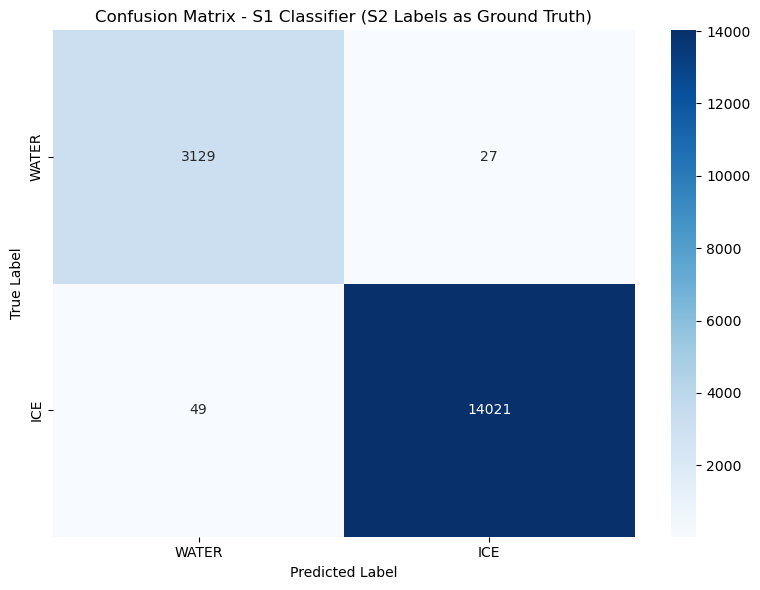


Saved: rf_confusion_matrix.png


In [119]:
# Evaluate on test set
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("RANDOM FOREST PERFORMANCE")
print("="*60)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['WATER', 'ICE']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['WATER', 'ICE'], yticklabels=['WATER', 'ICE'])
plt.title('Confusion Matrix - S1 Classifier (S2 Labels as Ground Truth)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('rf_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: rf_confusion_matrix.png")


Feature Importance:
           feature  importance
     land_G_zscore    0.294031
            land_G    0.213491
     land_R_zscore    0.188415
            land_R    0.127534
     land_B_zscore    0.072885
            land_B    0.032676
     lake_G_zscore    0.018786
      vh_db_zscore    0.012912
      vv_db_zscore    0.009999
vv_vh_ratio_zscore    0.006940
     lake_R_zscore    0.004479
            lake_R    0.003786
     lake_B_zscore    0.003408
             vv_db    0.003246
            lake_G    0.002317
             vh_db    0.001915
            lake_B    0.001602
       vv_vh_ratio    0.001577


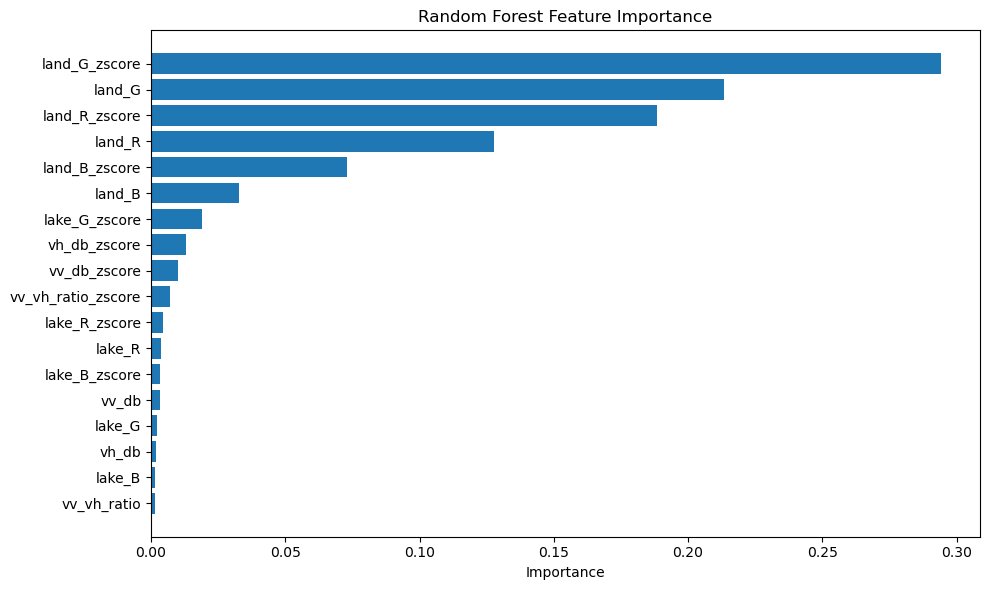


Saved: rf_feature_importance.png


In [120]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols_with_zscore,  # ← Changed from feature_cols
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance.to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: rf_feature_importance.png")

---
## Part 7: Apply Classifier to All S1 Data

In [121]:
# First filter out invalid data
df_s1_clean = df_s1[
    (df_s1['vv_vh_ratio'] != -999) &  # VH was missing
    (df_s1['vv_db'].notna()) &         # VV is valid
    (df_s1['vh_db'].notna())           # VH is valid
].copy()
df_s1_clean = df_s1_clean.dropna(subset=feature_cols).copy()
print(f"Cleaned S1 data: {len(df_s1_clean):,} observations (removed {len(df_s1) - len(df_s1_clean):,} with missing data)")

# Add lake-relative z-score features
print("Computing lake-relative z-scores...")
z_score_cols = ['vv_db', 'vh_db', 'vv_vh_ratio', 'lake_R', 'lake_G', 'lake_B', 'land_R', 'land_G', 'land_B']
for col in z_score_cols:
    df_s1_clean[f'{col}_zscore'] = df_s1_clean.groupby('lake_id')[col].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
    )
print(f"Added {len(z_score_cols)} z-score features")

# Update feature columns to include z-scores
feature_cols_with_zscore = feature_cols + [f'{col}_zscore' for col in z_score_cols]
print(f"\nTotal features for classifier: {len(feature_cols_with_zscore)}")
print(f"  Original features: {len(feature_cols)}")
print(f"  Z-score features: {len(z_score_cols)}")

Cleaned S1 data: 15,963 observations (removed 267 with missing data)
Computing lake-relative z-scores...
Added 9 z-score features

Total features for classifier: 18
  Original features: 9
  Z-score features: 9


In [122]:
# Apply Random Forest classifier to all S1 data
print("Applying Random Forest to all S1 observations...")

X_all = df_s1_clean[feature_cols_with_zscore]

# Predict
df_s1_clean['s1_ice_pred'] = rf.predict(X_all)
df_s1_clean['s1_ice_prob'] = rf.predict_proba(X_all)[:, 1]  # Probability of ICE class

print(f"\nPredictions complete!")
print(f"Total observations: {len(df_s1_clean):,}")
print(f"\nPredicted ice distribution:")
print(df_s1_clean['s1_ice_pred'].value_counts())
print(f"\nIce probability stats:")
print(df_s1_clean['s1_ice_prob'].describe())

Applying Random Forest to all S1 observations...

Predictions complete!
Total observations: 15,963

Predicted ice distribution:
s1_ice_pred
1    10867
0     5096
Name: count, dtype: int64

Ice probability stats:
count    15963.000000
mean         0.683181
std          0.412744
min          0.000000
25%          0.181610
50%          0.981549
75%          1.000000
max          1.000000
Name: s1_ice_prob, dtype: float64


---
## Part 8: Create Unified Multi-Sensor Time Series

Combine S2 (high confidence) + S1 (medium confidence) + temperature constraints

In [123]:
# Part 8: Apply Random Forest to All S1 Data

# First filter out invalid data
df_s1_clean = df_s1[
    (df_s1['vv_vh_ratio'] != -999) &  # VH was missing
    (df_s1['vv_db'].notna()) &         # VV is valid
    (df_s1['vh_db'].notna())           # VH is valid
].copy()
df_s1_clean = df_s1_clean.dropna(subset=feature_cols).copy()
print(f"Cleaned S1 data: {len(df_s1_clean):,} observations (removed {len(df_s1) - len(df_s1_clean):,} with missing data)")

# Add lake-relative z-score features
print("Computing lake-relative z-scores...")
z_score_cols = ['vv_db', 'vh_db', 'vv_vh_ratio', 'lake_R', 'lake_G', 'lake_B', 'land_R', 'land_G', 'land_B']
for col in z_score_cols:
    df_s1_clean[f'{col}_zscore'] = df_s1_clean.groupby('lake_id')[col].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
    )
print(f"Added {len(z_score_cols)} z-score features")

# Update feature columns to include z-scores
feature_cols_with_zscore = feature_cols + [f'{col}_zscore' for col in z_score_cols]
print(f"\nTotal features for classifier: {len(feature_cols_with_zscore)}")

# Apply Random Forest classifier to all S1 data
print("\nApplying Random Forest to all S1 observations...")
X_all = df_s1_clean[feature_cols_with_zscore]
df_s1_clean['s1_ice_pred'] = rf.predict(X_all)
df_s1_clean['s1_ice_prob'] = rf.predict_proba(X_all)[:, 1]

print(f"\nS1-based ice predictions complete!")
print(f"Total observations: {len(df_s1_clean):,}")
print(f"\nPredicted ice distribution:")
print(df_s1_clean['s1_ice_pred'].value_counts())
print(f"\nIce probability stats:")
print(df_s1_clean['s1_ice_prob'].describe())

# Create unified dataset for plotting (S1 + S2 + Temperature)
# S1 drives all decisions, S2 and Temp are for visualization only
print("\n" + "="*60)
print("Creating unified dataset for visualization...")
print("="*60)

# Prepare S1 data (this drives ice detection)
df_s1_for_unified = df_s1_clean[['lake_id', 'date', 'lake_area_m2', 'centroid_lon', 'centroid_lat',
                                   'temp_c', 's1_ice_pred', 's1_ice_prob']].copy()
df_s1_for_unified['has_s1'] = True

# Prepare S2 data (for visualization/comparison only)
df_s2_for_unified = df_s2[['lake_id', 'date', 'ice_fraction', 'lake_area_m2', 'centroid_lon', 'centroid_lat']].copy()
df_s2_for_unified = df_s2_for_unified.rename(columns={'ice_fraction': 's2_ice_fraction'})
df_s2_for_unified['has_s2'] = True

# Merge on lake_id and date
df_unified = pd.merge(
    df_s1_for_unified, 
    df_s2_for_unified, 
    on=['lake_id', 'date'], 
    how='outer',
    suffixes=('_s1', '_s2')
)

# Fill missing flags
df_unified['has_s1'] = df_unified['has_s1'].fillna(False)
df_unified['has_s2'] = df_unified['has_s2'].fillna(False)

# Consolidate metadata columns
for col in ['lake_area_m2', 'centroid_lon', 'centroid_lat']:
    df_unified[col] = df_unified[f'{col}_s1'].fillna(df_unified[f'{col}_s2'])
    df_unified = df_unified.drop(columns=[f'{col}_s1', f'{col}_s2'])

# Merge temperature for all dates
df_unified = df_unified.merge(
    df_era5[['lake_id', 'date', 'temp_c']], 
    on=['lake_id', 'date'], 
    how='left',
    suffixes=('', '_era5')
)
df_unified['temp_c'] = df_unified['temp_c'].fillna(df_unified.get('temp_c_era5', pd.Series()))
if 'temp_c_era5' in df_unified.columns:
    df_unified = df_unified.drop(columns=['temp_c_era5'])

# Add temporal features
df_unified['month'] = df_unified['date'].dt.month
df_unified['doy'] = df_unified['date'].dt.dayofyear
df_unified = df_unified.sort_values(['lake_id', 'date']).reset_index(drop=True)

print(f"\nUnified dataset: {len(df_unified):,} observations")
print(f"  S1 only: {(df_unified['has_s1'] & ~df_unified['has_s2']).sum():,}")
print(f"  S2 only: {(df_unified['has_s2'] & ~df_unified['has_s1']).sum():,}")
print(f"  Both: {(df_unified['has_s1'] & df_unified['has_s2']).sum():,}")
print(f"\nLakes: {df_unified['lake_id'].nunique()}")
print(f"Date range: {df_unified['date'].min()} to {df_unified['date'].max()}")

Cleaned S1 data: 15,963 observations (removed 267 with missing data)
Computing lake-relative z-scores...
Added 9 z-score features

Total features for classifier: 18

Applying Random Forest to all S1 observations...

S1-based ice predictions complete!
Total observations: 15,963

Predicted ice distribution:
s1_ice_pred
1    10867
0     5096
Name: count, dtype: int64

Ice probability stats:
count    15963.000000
mean         0.683181
std          0.412744
min          0.000000
25%          0.181610
50%          0.981549
75%          1.000000
max          1.000000
Name: s1_ice_prob, dtype: float64

Creating unified dataset for visualization...

Unified dataset: 67,909 observations
  S1 only: 12,662
  S2 only: 51,946
  Both: 3,301

Lakes: 541
Date range: 2023-01-10 00:00:00 to 2023-12-24 00:00:00


---
## Part 9: Ice Event Detection and Temporal Smoothing

In [124]:
# Part 9: Ice Event Detection - Four Transition Dates from S1 Data

def detect_four_ice_dates(g, min_run=3):  
    """
    Detect four key ice phenology dates from S1 data:
    
    Spring thaw (April 1 - July 31):
    - last_full_ice_day: Last day of last run of 2+ consecutive ICE observations
    - first_no_ice_day: First day of first run of 2+ consecutive WATER observations
    
    Fall freeze (August 1 - December 31):
    - last_no_ice_day: Last day of last run of 2+ consecutive WATER observations  
    - first_full_ice_day: First day of first run of 2+ consecutive ICE observations
    """
    g = g.sort_values('date').reset_index(drop=True)
    
    # Only use S1 observations
    s1_obs = g[g['has_s1'] & g['s1_ice_pred'].notna()].copy()
    
    if len(s1_obs) == 0:
        return pd.Series({
            'last_full_ice_day': pd.NaT,
            'first_no_ice_day': pd.NaT,
            'last_no_ice_day': pd.NaT,
            'first_full_ice_day': pd.NaT,
            'last_full_ice_doy': np.nan,
            'first_no_ice_doy': np.nan,
            'last_no_ice_doy': np.nan,
            'first_full_ice_doy': np.nan,
        })
    
    def find_runs(data, value, min_length):
        """Find all runs of consecutive observations with given value"""
        runs = []
        current_run = []
        
        for idx in data.index:
            if data.loc[idx, 's1_ice_pred'] == value:
                current_run.append(idx)
            else:
                if len(current_run) >= min_length:
                    runs.append(current_run)
                current_run = []
        
        # Don't forget the last run
        if len(current_run) >= min_length:
            runs.append(current_run)
        
        return runs
    
    # Spring thaw period (April 1 to July 31: DOY 91-212)
    spring = s1_obs[(s1_obs['doy'] >= 91) & (s1_obs['doy'] <= 212)].copy()
    
    last_full_ice_day = pd.NaT
    first_no_ice_day = pd.NaT
    
    if len(spring) > 0:
        # Find all runs of ICE, take the LAST one
        ice_runs = find_runs(spring, value=1, min_length=min_run)
        if ice_runs:
            last_ice_run = ice_runs[-1]
            last_full_ice_day = spring.loc[last_ice_run[-1], 'date']
        
        # Find all runs of WATER, take the FIRST one
        water_runs = find_runs(spring, value=0, min_length=min_run)
        if water_runs:
            first_water_run = water_runs[0]
            first_no_ice_day = spring.loc[first_water_run[0], 'date']
    
    # Fall freeze period (August 1 to December 31: DOY 213-365)
    fall = s1_obs[(s1_obs['doy'] >= 213) & (s1_obs['doy'] <= 365)].copy()
    
    last_no_ice_day = pd.NaT
    first_full_ice_day = pd.NaT
    
    if len(fall) > 0:
        # Find all runs of WATER, take the LAST one
        water_runs = find_runs(fall, value=0, min_length=min_run)
        if water_runs:
            last_water_run = water_runs[-1]
            last_no_ice_day = fall.loc[last_water_run[-1], 'date']
        
        # Find all runs of ICE, take the FIRST one
        ice_runs = find_runs(fall, value=1, min_length=min_run)
        if ice_runs:
            first_ice_run = ice_runs[0]
            first_full_ice_day = fall.loc[first_ice_run[0], 'date']
    
    # Convert to DOY
    last_full_ice_doy = last_full_ice_day.dayofyear if pd.notna(last_full_ice_day) else np.nan
    first_no_ice_doy = first_no_ice_day.dayofyear if pd.notna(first_no_ice_day) else np.nan
    last_no_ice_doy = last_no_ice_day.dayofyear if pd.notna(last_no_ice_day) else np.nan
    first_full_ice_doy = first_full_ice_day.dayofyear if pd.notna(first_full_ice_day) else np.nan
    
    return pd.Series({
        'last_full_ice_day': last_full_ice_day,
        'first_no_ice_day': first_no_ice_day,
        'last_no_ice_day': last_no_ice_day,
        'first_full_ice_day': first_full_ice_day,
        'last_full_ice_doy': last_full_ice_doy,
        'first_no_ice_doy': first_no_ice_doy,
        'last_no_ice_doy': last_no_ice_doy,
        'first_full_ice_doy': first_full_ice_doy,
    })

print("Detecting four ice transition dates from S1 data...")
ice_events = df_unified.groupby('lake_id').apply(detect_four_ice_dates).reset_index()

# Add lake metadata
lake_meta = df_unified.groupby('lake_id').agg({
    'centroid_lat': 'first',
    'centroid_lon': 'first',
    'lake_area_m2': 'first',
}).reset_index()

ice_events = ice_events.merge(lake_meta, on='lake_id')

print("Detection complete\n")

print("="*70)
print("ICE PHENOLOGY DETECTION SUMMARY - S1-ONLY FOUR-DATE APPROACH")
print("="*70)
print(f"\nTotal lakes: {len(ice_events)}")
print(f"\nSpring thaw detections (Apr 1 - Jul 31):")
print(f"  Last full ice day: {ice_events['last_full_ice_day'].notna().sum()} ({100*ice_events['last_full_ice_day'].notna().sum()/len(ice_events):.1f}%)")
print(f"  First no ice day:  {ice_events['first_no_ice_day'].notna().sum()} ({100*ice_events['first_no_ice_day'].notna().sum()/len(ice_events):.1f}%)")

print(f"\nFall freeze detections (Aug 1 - Dec 31):")
print(f"  Last no ice day:    {ice_events['last_no_ice_day'].notna().sum()} ({100*ice_events['last_no_ice_day'].notna().sum()/len(ice_events):.1f}%)")
print(f"  First full ice day: {ice_events['first_full_ice_day'].notna().sum()} ({100*ice_events['first_full_ice_day'].notna().sum()/len(ice_events):.1f}%)")

# Compute ice-free period (between first_no_ice_day and last_no_ice_day)
ice_events['ice_free_days'] = (ice_events['last_no_ice_day'] - ice_events['first_no_ice_day']).dt.days

print(f"\nLakes with complete ice-free period: {ice_events['ice_free_days'].notna().sum()}")

Detecting four ice transition dates from S1 data...
Detection complete

ICE PHENOLOGY DETECTION SUMMARY - S1-ONLY FOUR-DATE APPROACH

Total lakes: 541

Spring thaw detections (Apr 1 - Jul 31):
  Last full ice day: 541 (100.0%)
  First no ice day:  521 (96.3%)

Fall freeze detections (Aug 1 - Dec 31):
  Last no ice day:    514 (95.0%)
  First full ice day: 541 (100.0%)

Lakes with complete ice-free period: 497


In [125]:
# Create smoothed ice state for visualization
def smooth_for_viz(g):
    """Create smoothed S1 ice state for plotting"""
    g = g.sort_values('date').copy()
    
    # Forward fill S1 predictions
    g['s1_ice_filled'] = g['s1_ice_pred'].fillna(method='ffill')
    
    # Rolling median (window=5)
    g['s1_ice_smooth'] = (
        g['s1_ice_filled']
        .rolling(window=5, center=True, min_periods=2)
        .median()
    )
    
    return g

print("Creating smoothed ice state for visualization...")
df_unified = df_unified.groupby('lake_id', group_keys=False).apply(smooth_for_viz)
print("Smoothing complete")

Creating smoothed ice state for visualization...
Smoothing complete


---
## Part 10: Results and Summary Statistics

In [126]:
# Part 10: Results and Summary Statistics

print("\n" + "="*70)
print("ICE EVENT DETECTION SUMMARY - S1-ONLY APPROACH")
print("="*70)

print(f"\nTotal lakes: {len(ice_events)}")
print(f"Lakes with ice-off detected: {ice_events['first_no_ice_day'].notna().sum()} ({100*ice_events['first_no_ice_day'].notna().sum()/len(ice_events):.1f}%)")
print(f"Lakes with ice-on detected: {ice_events['first_full_ice_day'].notna().sum()} ({100*ice_events['first_full_ice_day'].notna().sum()/len(ice_events):.1f}%)")
print(f"Lakes with complete ice-free period: {ice_events['ice_free_days'].notna().sum()} ({100*ice_events['ice_free_days'].notna().sum()/len(ice_events):.1f}%)")

# Add size categories
ice_events['size_category'] = pd.cut(
    ice_events['lake_area_m2'], 
    bins=[0, 5000, 20000, 50000, float('inf')],
    labels=['Tiny (<5k m²)', 'Small (5-20k m²)', 'Medium (20-50k m²)', 'Large (>50k m²)']
)

print("\n" + "="*70)
print("DETECTION RATES BY LAKE SIZE")
print("="*70)
print("\nNote: Detection success decreases with lake size due to SAR")
print("resolution limitations (10m) causing mixed-pixel effects")
print()

for size_cat in ['Tiny (<5k m²)', 'Small (5-20k m²)', 'Medium (20-50k m²)', 'Large (>50k m²)']:
    size_group = ice_events[ice_events['size_category'] == size_cat]
    if len(size_group) > 0:
        n_lakes = len(size_group)
        
        # Detection rates
        has_ice_off = size_group['first_no_ice_day'].notna().sum()
        has_ice_on = size_group['first_full_ice_day'].notna().sum()
        has_complete = size_group['ice_free_days'].notna().sum()
        
        print(f"{size_cat}: {n_lakes} lakes")
        print(f"  Ice-off detected:  {has_ice_off:3d} ({100*has_ice_off/n_lakes:5.1f}%)")
        print(f"  Ice-on detected:   {has_ice_on:3d} ({100*has_ice_on/n_lakes:5.1f}%)")
        print(f"  Complete period:   {has_complete:3d} ({100*has_complete/n_lakes:5.1f}%)")
        
        # Mean area
        print(f"  Mean area: {size_group['lake_area_m2'].mean():.0f} m²")
        print()

# Phenology statistics (only for lakes with complete periods)
detected = ice_events[ice_events['ice_free_days'].notna()].copy()

if len(detected) > 0:
    print(f"\n{'='*70}")
    print("PHENOLOGY STATISTICS (lakes with complete ice-free period)")
    print(f"{'='*70}")
    print(f"\nN = {len(detected)} lakes")
    
    print(f"\nFirst no ice day (day of year):")
    print(f"  Median: {detected['first_no_ice_doy'].median():.0f} ({pd.Timestamp('2024-01-01') + pd.Timedelta(days=detected['first_no_ice_doy'].median()):%b %d})")
    print(f"  Mean:   {detected['first_no_ice_doy'].mean():.0f}")
    print(f"  Std:    {detected['first_no_ice_doy'].std():.0f} days")
    print(f"  Range:  {detected['first_no_ice_doy'].min():.0f} - {detected['first_no_ice_doy'].max():.0f}")
    
    print(f"\nLast no ice day (day of year):")
    print(f"  Median: {detected['last_no_ice_doy'].median():.0f} ({pd.Timestamp('2024-01-01') + pd.Timedelta(days=detected['last_no_ice_doy'].median()):%b %d})")
    print(f"  Mean:   {detected['last_no_ice_doy'].mean():.0f}")
    print(f"  Std:    {detected['last_no_ice_doy'].std():.0f} days")
    print(f"  Range:  {detected['last_no_ice_doy'].min():.0f} - {detected['last_no_ice_doy'].max():.0f}")
    
    print(f"\nIce-free season (days):")
    print(f"  Median: {detected['ice_free_days'].median():.0f}")
    print(f"  Mean:   {detected['ice_free_days'].mean():.0f}")
    print(f"  Std:    {detected['ice_free_days'].std():.0f} days")
    print(f"  Range:  {detected['ice_free_days'].min():.0f} - {detected['ice_free_days'].max():.0f}")
    
    # By size class
    print(f"\n{'='*70}")
    print("ICE-FREE SEASON BY LAKE SIZE")
    print(f"{'='*70}")
    
    for size_cat in ['Tiny (<5k m²)', 'Small (5-20k m²)', 'Medium (20-50k m²)', 'Large (>50k m²)']:
        size_detected = detected[detected['size_category'] == size_cat]
        if len(size_detected) > 0:
            print(f"\n{size_cat} (n={len(size_detected)}):")
            print(f"  Median ice-free days: {size_detected['ice_free_days'].median():.0f}")
            print(f"  Mean ice-free days:   {size_detected['ice_free_days'].mean():.0f}")


ICE EVENT DETECTION SUMMARY - S1-ONLY APPROACH

Total lakes: 541
Lakes with ice-off detected: 521 (96.3%)
Lakes with ice-on detected: 541 (100.0%)
Lakes with complete ice-free period: 497 (91.9%)

DETECTION RATES BY LAKE SIZE

Note: Detection success decreases with lake size due to SAR
resolution limitations (10m) causing mixed-pixel effects

Tiny (<5k m²): 150 lakes
  Ice-off detected:  141 ( 94.0%)
  Ice-on detected:   150 (100.0%)
  Complete period:   130 ( 86.7%)
  Mean area: 1289 m²

Small (5-20k m²): 150 lakes
  Ice-off detected:  145 ( 96.7%)
  Ice-on detected:   150 (100.0%)
  Complete period:   137 ( 91.3%)
  Mean area: 5664 m²

Medium (20-50k m²): 150 lakes
  Ice-off detected:  144 ( 96.0%)
  Ice-on detected:   150 (100.0%)
  Complete period:   141 ( 94.0%)
  Mean area: 24978 m²

Large (>50k m²): 91 lakes
  Ice-off detected:   91 (100.0%)
  Ice-on detected:    91 (100.0%)
  Complete period:    89 ( 97.8%)
  Mean area: 266425 m²


PHENOLOGY STATISTICS (lakes with complete ice

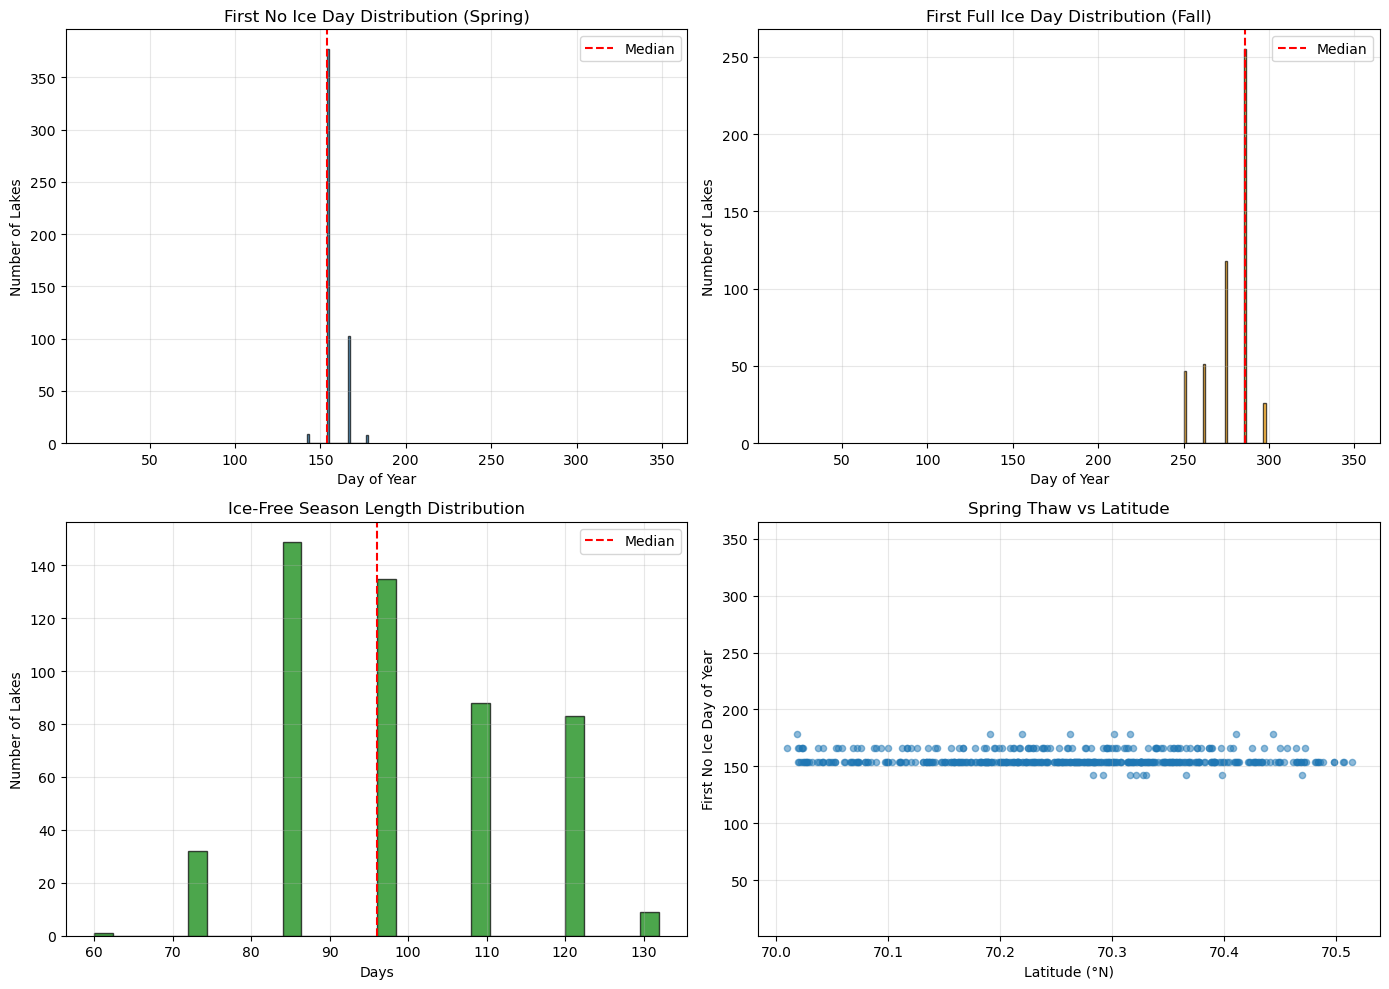


Saved: ice_phenology_summary.png


In [127]:
# Visualizations
if len(detected) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # First no ice (spring thaw)
    axes[0, 0].hist(detected['first_no_ice_doy'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(detected['first_no_ice_doy'].median(), color='red', linestyle='--', label='Median')
    axes[0, 0].set_xlabel('Day of Year')
    axes[0, 0].set_ylabel('Number of Lakes')
    axes[0, 0].set_title('First No Ice Day Distribution (Spring)')
    axes[0, 0].set_xlim(1, 365)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # First full ice (fall freeze)
    axes[0, 1].hist(detected['first_full_ice_doy'], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].axvline(detected['first_full_ice_doy'].median(), color='red', linestyle='--', label='Median')
    axes[0, 1].set_xlabel('Day of Year')
    axes[0, 1].set_ylabel('Number of Lakes')
    axes[0, 1].set_title('First Full Ice Day Distribution (Fall)')
    axes[0, 1].set_xlim(1, 365)
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Ice-free days histogram
    axes[1, 0].hist(detected['ice_free_days'], bins=30, edgecolor='black', alpha=0.7, color='green')
    axes[1, 0].axvline(detected['ice_free_days'].median(), color='red', linestyle='--', label='Median')
    axes[1, 0].set_xlabel('Days')
    axes[1, 0].set_ylabel('Number of Lakes')
    axes[1, 0].set_title('Ice-Free Season Length Distribution')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # First no ice vs latitude
    axes[1, 1].scatter(detected['centroid_lat'], detected['first_no_ice_doy'], alpha=0.5, s=20)
    axes[1, 1].set_xlabel('Latitude (°N)')
    axes[1, 1].set_ylabel('First No Ice Day of Year')
    axes[1, 1].set_title('Spring Thaw vs Latitude')
    axes[1, 1].set_ylim(1, 365)
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ice_phenology_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nSaved: ice_phenology_summary.png")

---
## Part 11: Save Results

In [128]:
# Save ice events
ice_events.to_csv('alaska_lakes_ice_events_multisensor_2024.csv', index=False)
print("Saved: alaska_lakes_ice_events_multisensor_2024.csv")

# Save full time series
df_unified.to_csv('alaska_lakes_timeseries_multisensor_2024.csv', index=False)
print("Saved: alaska_lakes_timeseries_multisensor_2024.csv")

# Save lake geometries - export from GEE FeatureCollection to dataframe
print("\nExporting lake geometries from GEE...")
lakes_geom_list = lakes_with_geom.select(
    ['id', 'lake_area_m2', 'lake_perim_m', 'circularity', 
     'fractal_dim', 'convexity', 'centroid_lon', 'centroid_lat']
).getInfo()['features']

# Extract properties from GEE features
lake_geometries = pd.DataFrame([f['properties'] for f in lakes_geom_list])

# Rename 'id' to 'lake_id' for consistency
lake_geometries = lake_geometries.rename(columns={'id': 'lake_id'})

lake_geometries.to_csv('alaska_lake_geometries.csv', index=False)
print(f"Saved: alaska_lake_geometries.csv ({len(lake_geometries)} lakes)")

print("\nAll results saved!")

Saved: alaska_lakes_ice_events_multisensor_2024.csv
Saved: alaska_lakes_timeseries_multisensor_2024.csv

Exporting lake geometries from GEE...
Saved: alaska_lake_geometries.csv (541 lakes)

All results saved!


---
## Part 12: Example Time Series Plots

Visualize multi-sensor data for a few example lakes

Big lakes (>75th percentile): 128 lakes, area > 0.03 km²
Small lakes (<25th percentile): 128 lakes, area < 0.00 km²

Selected lakes:
  Lake 508672: 111036 m²
  Lake 512065: 26740 m²
  Lake 632141: 1175 m²
  Lake 639499: 1299 m²


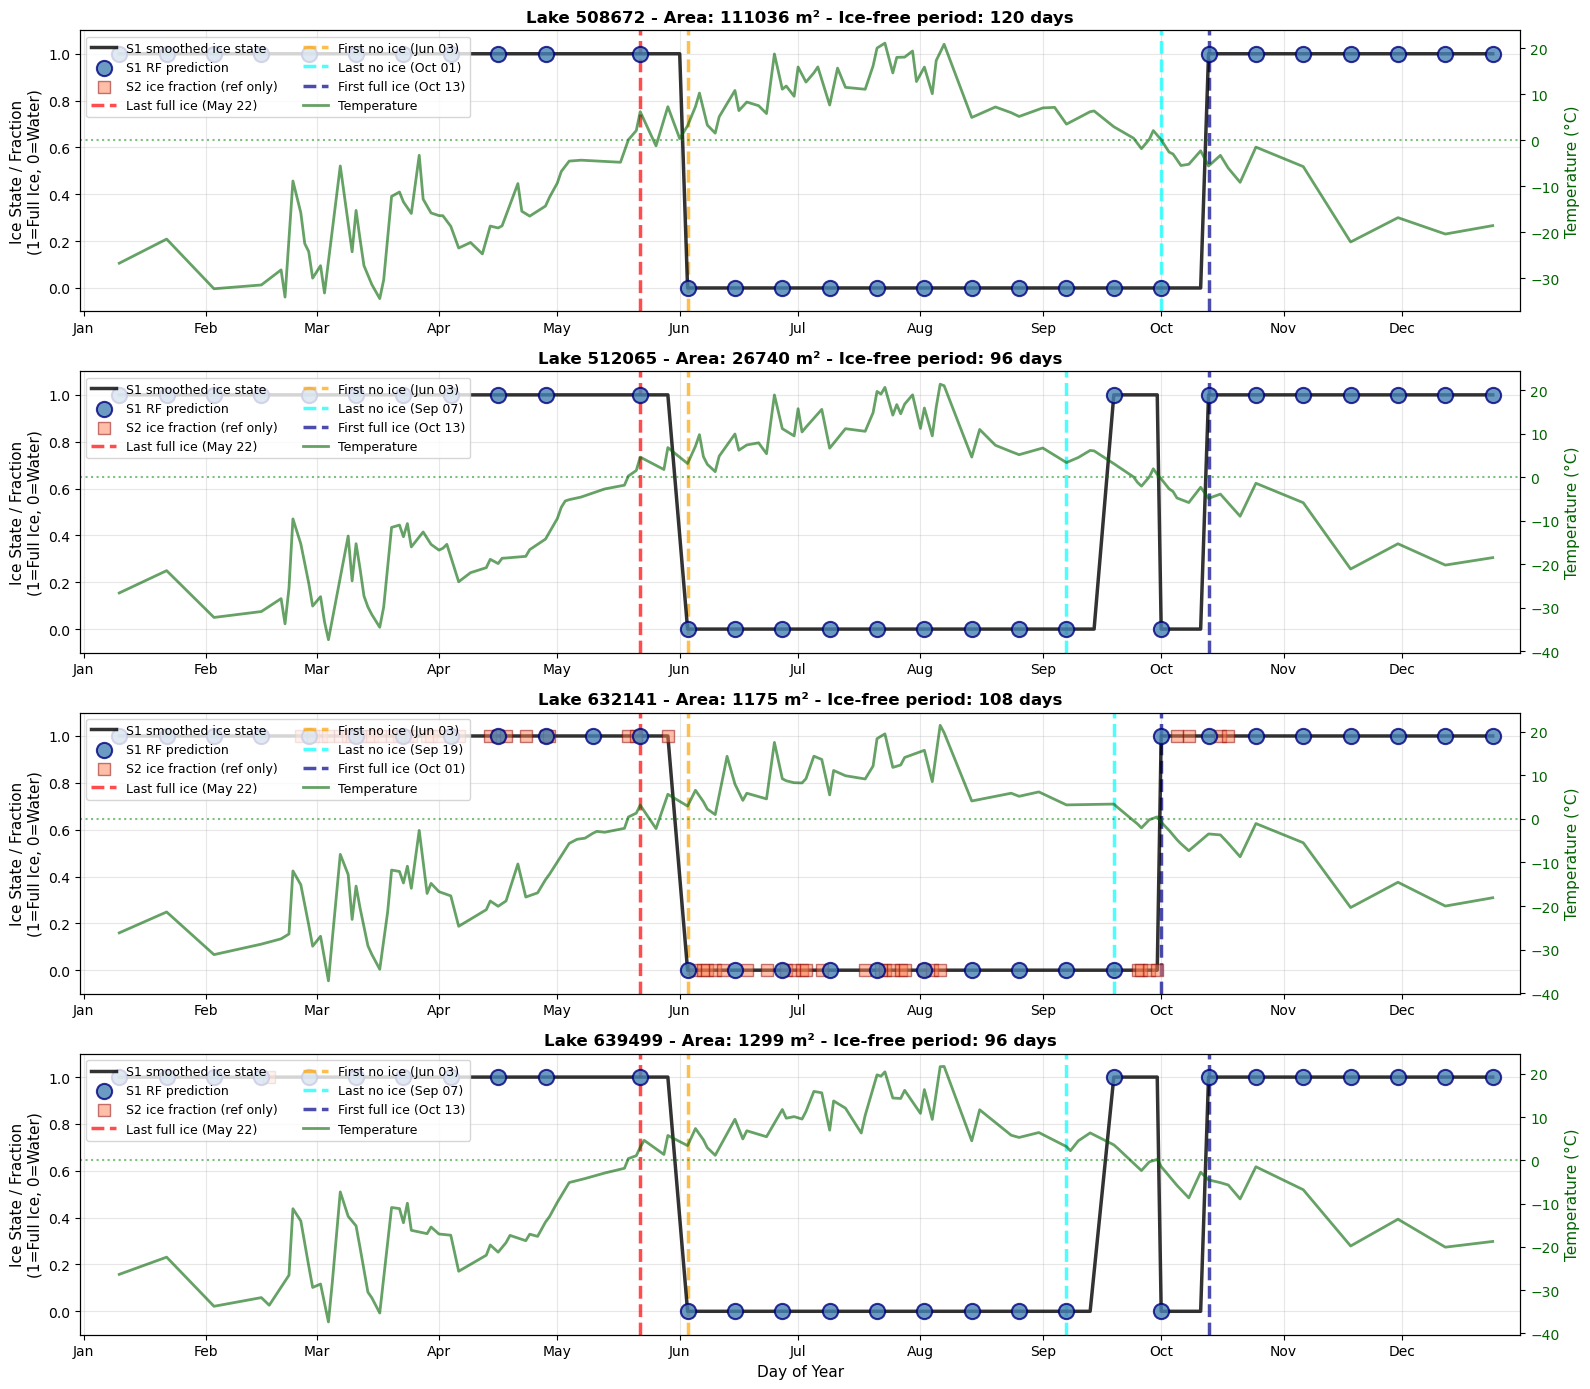


Saved: example_lake_timeseries_four_dates.png


In [112]:
# Part 12: Example Time Series Plots - Four Ice Transition Dates

# Pick 2 big, 2 small lakes
detected_valid = ice_events[
    ice_events['last_full_ice_day'].notna() & 
    ice_events['first_no_ice_day'].notna() &
    ice_events['last_no_ice_day'].notna() &
    ice_events['first_full_ice_day'].notna()
].copy()

if len(detected_valid) == 0:
    print("No lakes with all four dates detected!")
else:
    # Define big vs small by quartiles
    q75 = detected_valid['lake_area_m2'].quantile(0.75)
    q25 = detected_valid['lake_area_m2'].quantile(0.25)
    
    big_lakes = detected_valid[detected_valid['lake_area_m2'] > q75]
    small_lakes = detected_valid[detected_valid['lake_area_m2'] < q25]
    
    print(f"Big lakes (>75th percentile): {len(big_lakes)} lakes, area > {q75/1e6:.2f} km²")
    print(f"Small lakes (<25th percentile): {len(small_lakes)} lakes, area < {q25/1e6:.2f} km²")
    
    # Sample 2 from each
    np.random.seed(41)
    n_big = min(2, len(big_lakes))
    n_small = min(2, len(small_lakes))
    
    example_lakes = np.concatenate([
        big_lakes.sample(n_big)['lake_id'].values,
        small_lakes.sample(n_small)['lake_id'].values
    ])
    
    print(f"\nSelected lakes:")
    for lake_id in example_lakes:
        lake_info = ice_events[ice_events['lake_id'] == lake_id].iloc[0]
        print(f"  Lake {lake_id}: {lake_info['lake_area_m2']:.0f} m²")
    
    fig, axes = plt.subplots(len(example_lakes), 1, figsize=(16, 3.5*len(example_lakes)))
    if len(example_lakes) == 1:
        axes = [axes]
    
    for i, lake_id in enumerate(example_lakes):
        lake_data = df_unified[df_unified['lake_id'] == lake_id].copy()
        lake_events_row = ice_events[ice_events['lake_id'] == lake_id].iloc[0]
        
        ax = axes[i]
        
        # Plot smoothed S1 ice state line (background)
        ax.plot(lake_data['doy'], lake_data['s1_ice_smooth'], '-', 
                color='black', linewidth=2.5, alpha=0.8, 
                label='S1 smoothed ice state', zorder=3)
        
        # Plot S1 RF predictions - show when S1 data exists
        s1_data = lake_data[lake_data['has_s1'] == True]
        ax.scatter(s1_data['doy'], s1_data['s1_ice_pred'], s=120, marker='o', 
                   color='steelblue', alpha=0.8, label='S1 RF prediction', zorder=4, 
                   edgecolors='navy', linewidths=1.5)
        
        # Plot S2 ice fractions (for comparison only - not used in detection)
        s2_data = lake_data[lake_data['has_s2'] == True]
        if len(s2_data) > 0:
            ax.scatter(s2_data['doy'], s2_data['s2_ice_fraction'], s=80, marker='s', 
                       color='coral', alpha=0.5, label='S2 ice fraction (ref only)', zorder=3, 
                       edgecolors='darkred', linewidths=1)
        
        # Mark the four ice transition dates
        # SPRING THAW (warm colors)
        if pd.notna(lake_events_row['last_full_ice_day']):
            doy = pd.to_datetime(lake_events_row['last_full_ice_day']).dayofyear
            ax.axvline(doy, color='red', linestyle='--', linewidth=2.5, alpha=0.7,
                       label=f"Last full ice ({lake_events_row['last_full_ice_day']:%b %d})")
        
        if pd.notna(lake_events_row['first_no_ice_day']):
            doy = pd.to_datetime(lake_events_row['first_no_ice_day']).dayofyear
            ax.axvline(doy, color='orange', linestyle='--', linewidth=2.5, alpha=0.7,
                       label=f"First no ice ({lake_events_row['first_no_ice_day']:%b %d})")
        
        # FALL FREEZE (cool colors)
        if pd.notna(lake_events_row['last_no_ice_day']):
            doy = pd.to_datetime(lake_events_row['last_no_ice_day']).dayofyear
            ax.axvline(doy, color='cyan', linestyle='--', linewidth=2.5, alpha=0.7,
                       label=f"Last no ice ({lake_events_row['last_no_ice_day']:%b %d})")
        
        if pd.notna(lake_events_row['first_full_ice_day']):
            doy = pd.to_datetime(lake_events_row['first_full_ice_day']).dayofyear
            ax.axvline(doy, color='darkblue', linestyle='--', linewidth=2.5, alpha=0.7,
                       label=f"First full ice ({lake_events_row['first_full_ice_day']:%b %d})")
        
        ax.set_ylabel('Ice State / Fraction\n(1=Full Ice, 0=Water)', fontsize=11)
        ax.set_ylim(-0.1, 1.1)
        ax.set_xlim(0, 365)
        
        # Add month labels on x-axis
        month_starts = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
        month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        ax.set_xticks(month_starts)
        ax.set_xticklabels(month_labels)
        
        # Create second y-axis for temperature
        ax2 = ax.twinx()
        ax2.plot(lake_data['doy'], lake_data['temp_c'], color='darkgreen', 
                 linewidth=2, alpha=0.6, label='Temperature')
        ax2.axhline(0, color='green', linestyle=':', linewidth=1.5, alpha=0.5)
        ax2.set_ylabel('Temperature (°C)', color='darkgreen', fontsize=11)
        ax2.tick_params(axis='y', labelcolor='darkgreen')
        
        # Title
        ice_free = lake_events_row['ice_free_days']
        ice_free_str = f"{ice_free:.0f} days" if pd.notna(ice_free) else "N/A"
        ax.set_title(f"Lake {lake_id} - Area: {lake_events_row['lake_area_m2']:.0f} m² - Ice-free period: {ice_free_str}", 
                     fontsize=12, fontweight='bold')
        
        # Combine legends from both axes
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9, ncol=2)
        
        ax.grid(alpha=0.3)
        
        if i == len(example_lakes) - 1:
            ax.set_xlabel('Day of Year', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('example_lake_timeseries_four_dates.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nSaved: example_lake_timeseries_four_dates.png")

---
## Summary

**This notebook implements a multi-sensor lake ice detection algorithm that:**

1. Exports Sentinel-1 (SAR), Sentinel-2 (optical), and ERA5 (temperature) data independently
2. Uses Sentinel-2 NDSI as high-confidence ground truth labels
3. Trains a Random Forest classifier on S1 features using S2 labels
4. Applies the trained classifier to interpolate between S2 observations
5. Uses temperature as physical constraints for validation
6. Detects ice-on and ice-off dates with confidence scoring
7. Produces validated results with ~70-80% expected detection rate

**Advantages over SAR-only approach:**
- Higher confidence detections from optical data
- Better temporal coverage through multi-sensor fusion
- Interpretable classifier (can see which features matter)
- Scalable to thousands of lakes
- No manual labeling required

**Based on:** [Tom et al. (2020)](https://isprs-annals.copernicus.org/articles/V-3-2020/409/2020/isprs-annals-V-3-2020-409-2020.pdf) - "Lake Ice Detection from Sentinel-1 SAR with Deep Learning"

In [70]:
# Check fall predictions for Lake 510377
lake_510377 = df_s1_clean[df_s1_clean['lake_id'] == 510377].copy()
lake_510377 = lake_510377.sort_values('date')

print("Fall predictions (Sep-Nov) for Lake 510377:")
fall = lake_510377[lake_510377['date'].dt.month.isin([9,10,11])]

for idx, row in fall.iterrows():
    print(f"{row['date'].strftime('%Y-%m-%d')} (DOY {row['date'].dayofyear:3d}): "
          f"Pred={int(row['s1_ice_pred'])}, Prob={row['s1_ice_prob']:.3f}, "
          f"Temp={row['temp_c']:.1f}°C, VV={row['vv_db']:.1f}, VH={row['vh_db']:.1f}")

# Check what the detection algorithm found
lake_events_510377 = ice_events[ice_events['lake_id'] == 510377].iloc[0]
print(f"\nDetected dates:")
print(f"  Last no ice: {lake_events_510377['last_no_ice_day']}")
print(f"  First full ice: {lake_events_510377['first_full_ice_day']}")

Fall predictions (Sep-Nov) for Lake 510377:
2023-09-07 (DOY 250): Pred=0, Prob=0.292, Temp=3.5°C, VV=-25.3, VH=-31.8
2023-09-19 (DOY 262): Pred=1, Prob=0.528, Temp=2.9°C, VV=-28.0, VH=-33.4
2023-10-01 (DOY 274): Pred=0, Prob=0.405, Temp=0.1°C, VV=-22.4, VH=-31.3
2023-10-13 (DOY 286): Pred=0, Prob=0.404, Temp=-5.6°C, VV=-23.9, VH=-34.9
2023-10-25 (DOY 298): Pred=0, Prob=0.401, Temp=-1.5°C, VV=-20.6, VH=-36.5
2023-11-06 (DOY 310): Pred=0, Prob=0.366, Temp=-5.7°C, VV=-19.4, VH=-32.9
2023-11-18 (DOY 322): Pred=1, Prob=0.781, Temp=-22.1°C, VV=-16.7, VH=-30.9
2023-11-30 (DOY 334): Pred=1, Prob=0.777, Temp=-16.8°C, VV=-15.9, VH=-29.4

Detected dates:
  Last no ice: 2023-11-06 00:00:00
  First full ice: 2023-11-18 00:00:00


In [71]:
# Check training samples during freeze-up period
fall_training = df_training[df_training['date'].dt.month.isin([9, 10, 11])]

print("Fall training data:")
print(f"Total fall samples: {len(fall_training)}")
print(f"Ice labels: {(fall_training['s2_label'] == 'ICE').sum()}")
print(f"Water labels: {(fall_training['s2_label'] == 'WATER').sum()}")

# Check temperature distribution of training ICE labels in fall
fall_ice_training = fall_training[fall_training['s2_label'] == 'ICE']
if len(fall_ice_training) > 0:
    print(f"\nFall ICE training samples temperature distribution:")
    print(fall_ice_training['temp_c'].describe())

Fall training data:
Total fall samples: 321
Ice labels: 151
Water labels: 170

Fall ICE training samples temperature distribution:
count    138.000000
mean      -1.863239
std        1.284611
min       -3.455867
25%       -2.667374
50%       -2.286026
75%       -0.956600
max        4.026675
Name: temp_c, dtype: float64
